Load the Dataset

In [68]:
import pandas as pd

df = pd.read_csv('Super Lig.csv')


Create Features "Season"


In [70]:

season_lengths = [306]*15 +[272]+ [306]*9+[306]+[420]+[380]+[342]
 
season_labels = [f"{1994 + i}-{str(1995 + i)[-2:]}" for i in range(29)]

season_list = [label for label, count in zip(season_labels, season_lengths) for _ in range(count)]

df['Season'] = season_list

Create DF2

In [71]:
df2 = df[(df['HomeGoals'] < 6) & (df['AwayGoals'] < 6)].reset_index(drop=True)


Create DF3



In [72]:
# Make a copy of the original dataframe
df3 = df.copy().sort_values(['Season', 'Date']).reset_index(drop=True)

# Initialize column
df3['new_promoted'] = 'No'

# Get unique seasons in order
seasons = sorted(df3['Season'].unique())

# Loop from the 2nd season onward (compare with previous season)
for i in range(1, len(seasons)):
    current_season = seasons[i]
    prev_season = seasons[i - 1]
    
    # Teams in current and previous season
    current_teams = set(pd.concat([df3.loc[df3['Season'] == current_season, 'HomeTeam'],
                                   df3.loc[df3['Season'] == current_season, 'AwayTeam']]))
    prev_teams = set(pd.concat([df3.loc[df3['Season'] == prev_season, 'HomeTeam'],
                                df3.loc[df3['Season'] == prev_season, 'AwayTeam']]))
    
    # Newly promoted teams = in current but not in previous
    new_teams = current_teams - prev_teams
    
    # Mark all matches in current season where either home or away team is new
    mask = (df3['Season'] == current_season) & (
        df3['HomeTeam'].isin(new_teams) | df3['AwayTeam'].isin(new_teams)
    )
    df3.loc[mask, 'new_promoted'] = 'Yes'


In [73]:
df3 = df3[df3['new_promoted'] == 'No'].reset_index(drop=True)

Create DF4


In [74]:
df4 = df3[(df3['HomeGoals'] < 6) & (df3['AwayGoals'] < 6)].reset_index(drop=True)

Find out the best Dataframe first



=== Season-wise Accuracy for All DataFrames (Simple mean) ===
 Season    df   df2   df3   df4
1996-97  7.95  9.76  8.33  9.29
1997-98 12.39 11.90 12.12 14.06
1998-99 10.05 10.22 10.67 10.88
1999-00 11.93 13.33  9.62  9.80
2000-01 14.36 13.19 10.26 11.54
2001-02 11.36 11.49 10.90 10.32
2002-03  9.82 10.60  9.85 10.85
2003-04  9.17  8.37 10.85  9.60
2004-05 11.93 12.28 10.32  8.73
2005-06 17.37 17.28 13.95 13.60
2006-07 19.40 18.70 12.64 10.34
2007-08 12.86 13.04 15.23 15.54
2008-09  9.78 10.41  9.87  8.55
2009-10 12.60 12.30 13.64 13.64
2010-11 10.66 10.45 10.96 10.64
2011-12 11.25 11.76 10.80  9.77
2012-13 12.50 12.50 11.84 11.26
2013-14  8.93  9.39  9.09  9.92
2014-15 11.03 10.00 11.76 10.74
2015-16 11.40 11.99 12.85 13.07
2016-17  7.69  9.02  6.59  6.70
2017-18 12.55 13.52 12.82 12.42
2018-19 12.96 13.17 14.39 13.74
2019-20  8.82  8.92 10.29 11.11
2020-21 10.77 11.26 10.45 12.50
2021-22 13.48 15.50 15.43 15.76
2022-23  9.82  8.19 10.79  9.02
Average 11.59 11.80 11.34 11.24


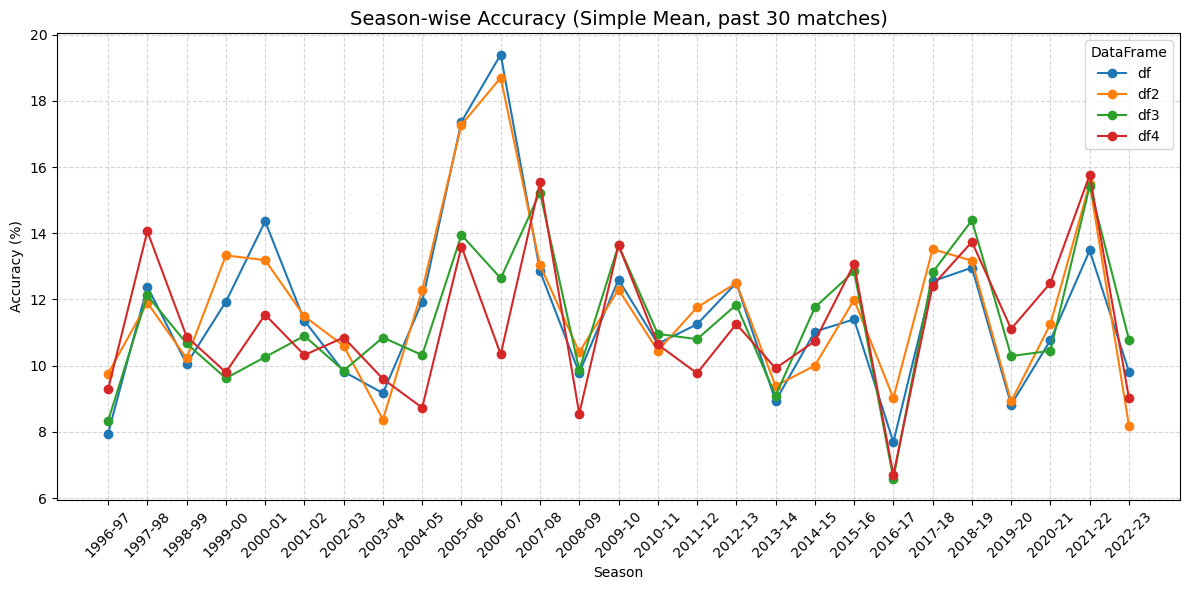

In [75]:
#simple mean approach

import pandas as pd
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

# === Function for Poisson prediction (simple mean model) ===
def run_poisson_prediction(df_input, past_n=30):
    df_copy = df_input.copy()
    df_copy['Date'] = pd.to_datetime(df_copy['Date'], dayfirst=True, errors='coerce')
    df_copy = df_copy.dropna(subset=['Date']).sort_values('Date').reset_index(drop=True)
    df_copy['PredictionMatch'] = '0'

    def predict_match(row, df_data):
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        match_date = row['Date']

        # Past matches
        past_home = df_data[(df_data['HomeTeam'] == home_team) & (df_data['Date'] < match_date)]\
                        .sort_values('Date', ascending=False).head(past_n)
        past_away = df_data[(df_data['AwayTeam'] == away_team) & (df_data['Date'] < match_date)]\
                        .sort_values('Date', ascending=False).head(past_n)

        if len(past_home) < past_n or len(past_away) < past_n:
            return '0'

        # Simple mean goals
        lambda_home = past_home['HomeGoals'].mean()
        lambda_away = past_away['AwayGoals'].mean()

        # Score prediction matrix
        max_goals = 10
        score_matrix = np.zeros((max_goals + 1, max_goals + 1))
        for i in range(max_goals + 1):
            for j in range(max_goals + 1):
                score_matrix[i, j] = poisson.pmf(i, lambda_home) * poisson.pmf(j, lambda_away)

        pred_home, pred_away = np.unravel_index(np.argmax(score_matrix), score_matrix.shape)
        return 'Yes' if (pred_home == row['HomeGoals']) and (pred_away == row['AwayGoals']) else 'No'

    # Seasons to check
    seasons_to_check = [f"{y}-{str(y+1)[-2:]}" for y in range(1996, 2023)]
    season_accuracies = []

    # Calculate season-wise accuracy
    for season in seasons_to_check:
        mask = df_copy['Season'] == season
        df_copy.loc[mask, 'PredictionMatch'] = df_copy[mask].apply(lambda row: predict_match(row, df_copy), axis=1)
        pred_df = df_copy[(df_copy['Season'] == season) & (df_copy['PredictionMatch'].isin(['Yes', 'No']))]
        correct = (pred_df['PredictionMatch'] == 'Yes').sum()
        total = len(pred_df)
        accuracy = correct / total if total > 0 else 0
        season_accuracies.append((season, round(accuracy * 100, 2)))

    return pd.DataFrame(season_accuracies, columns=['Season', 'Accuracy (%)'])

# === Run for all DataFrames ===
results_dfs = {}
for name, dataset in zip(['df', 'df2', 'df3', 'df4'], [df, df2, df3, df4]):
    results_dfs[name] = run_poisson_prediction(dataset, past_n=30)

# === Combine into one table ===
combined = results_dfs['df'][['Season']].copy()
for name in results_dfs:
    combined[name] = results_dfs[name]['Accuracy (%)']

# === Append average accuracy row ===
avg_row = {'Season': 'Average'}
for name in results_dfs:
    avg_row[name] = round(combined[name].mean(), 2)
combined = pd.concat([combined, pd.DataFrame([avg_row])], ignore_index=True)

# === Print table ===
print("\n=== Season-wise Accuracy for All DataFrames (Simple mean) ===")
print(combined.to_string(index=False))

# === Plot line chart ===
plt.figure(figsize=(12, 6))
for name in ['df', 'df2', 'df3', 'df4']:
    plt.plot(combined['Season'][:-1], combined[name][:-1], marker='o', label=name)

plt.title("Season-wise Accuracy (Simple Mean, past 30 matches)", fontsize=14)
plt.xlabel("Season")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="DataFrame")
plt.tight_layout()
plt.show()


DF2 works best , Next Find the best 'N'



=== Poisson Prediction Accuracy by History Length (DF2) ===
 Season  Last_10  Last_20  Last_30  Last_40  Last_50
1997-98     9.34    11.40    11.90    12.87    11.76
1998-99    10.29    10.84    10.22    10.59    10.90
1999-00     8.85    10.96    13.33    12.75    12.75
2000-01    10.57    13.57    13.19    14.12    12.18
2001-02     8.75    12.16    11.49    10.32    10.32
2002-03    10.00    12.99    10.60    10.31    12.43
2003-04     9.09     7.73     8.37     9.50     6.77
2004-05     9.96     9.55    12.28     9.62    10.26
2005-06    11.89    13.92    17.28    15.28    14.73
2006-07    12.13    14.29    18.70    17.42    11.94
2007-08     8.94    14.01    13.04    14.36    14.10
2008-09    11.62     9.65    10.41    10.48    10.48
2009-10    12.59    14.02    12.30    14.08    13.26
2010-11    12.41     8.21    10.45    10.70    11.82
2011-12    11.32    10.50    11.76    11.76    11.81
2012-13     9.44     9.58    12.50     9.05    12.15
2013-14    11.88    11.78     9.39    

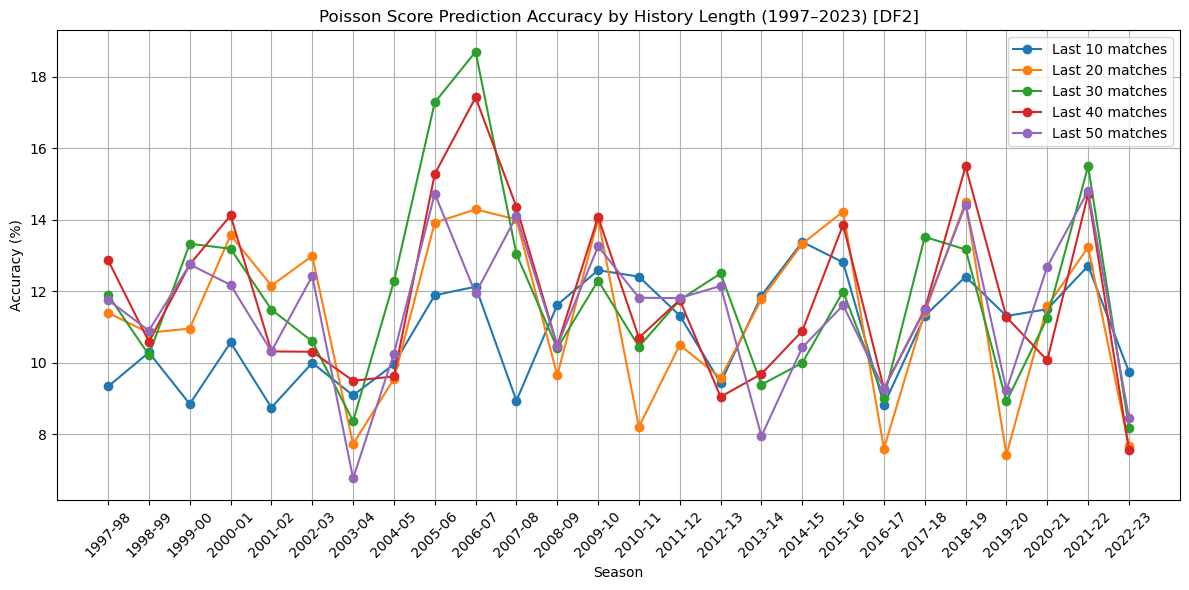

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

# Prepare dataset
df2['Date'] = pd.to_datetime(df2['Date'], dayfirst=True, errors='coerce')
df2 = df2.dropna(subset=['Date']).sort_values('Date').reset_index(drop=True)

# Define seasons to check
seasons_to_check = [f"{y}-{str(y+1)[-2:]}" for y in range(1997, 2023)]

# History lengths to test
history_lengths = [10, 20, 30, 40, 50]

# Accuracy results
accuracy_results = {h: [] for h in history_lengths}

# Function to predict using Poisson model
def predict_match(row, df, history_len):
    home_team = row['HomeTeam']
    away_team = row['AwayTeam']
    match_date = row['Date']
    
    past_home = df[(df['HomeTeam'] == home_team) & (df['Date'] < match_date)].sort_values('Date', ascending=False).head(history_len)
    past_away = df[(df['AwayTeam'] == away_team) & (df['Date'] < match_date)].sort_values('Date', ascending=False).head(history_len)
    
    if len(past_home) < history_len or len(past_away) < history_len:
        return '0'
    
    lambda_home = past_home['HomeGoals'].mean()
    lambda_away = past_away['AwayGoals'].mean()
    
    max_goals = 10
    score_matrix = np.zeros((max_goals + 1, max_goals + 1))
    
    for i in range(max_goals + 1):
        for j in range(max_goals + 1):
            score_matrix[i, j] = poisson.pmf(i, lambda_home) * poisson.pmf(j, lambda_away)
    
    pred_home, pred_away = np.unravel_index(np.argmax(score_matrix), score_matrix.shape)
    return 'Yes' if (pred_home == row['HomeGoals']) and (pred_away == row['AwayGoals']) else 'No'

# Loop for each history length
for h_len in history_lengths:
    df2[f'Prediction_{h_len}'] = '0'
    
    # Apply predictions season by season
    for season in seasons_to_check:
        mask = df2['Season'] == season
        df2.loc[mask, f'Prediction_{h_len}'] = df2[mask].apply(lambda row: predict_match(row, df2, h_len), axis=1)

    # Evaluate accuracy per season
    for season in seasons_to_check:
        pred_df = df2[(df2['Season'] == season) & (df2[f'Prediction_{h_len}'].isin(['Yes', 'No']))]
        correct = (pred_df[f'Prediction_{h_len}'] == 'Yes').sum()
        total = len(pred_df)
        accuracy = correct / total if total > 0 else 0
        accuracy_results[h_len].append(round(accuracy * 100, 2))  # store as %

# === Create Accuracy Table ===
accuracy_df = pd.DataFrame({'Season': seasons_to_check})
for h_len in history_lengths:
    accuracy_df[f'Last_{h_len}'] = accuracy_results[h_len]

# Add average row
avg_row = {'Season': 'Average'}
for h_len in history_lengths:
    avg_row[f'Last_{h_len}'] = round(np.mean(accuracy_results[h_len]), 2)
accuracy_df = pd.concat([accuracy_df, pd.DataFrame([avg_row])], ignore_index=True)

# Print table
print("\n=== Poisson Prediction Accuracy by History Length (DF2) ===")
print(accuracy_df.to_string(index=False))

# === Plotting ===
plt.figure(figsize=(12, 6))
for h_len in history_lengths:
    plt.plot(seasons_to_check, [acc for acc in accuracy_results[h_len]], marker='o', label=f'Last {h_len} matches')

plt.xticks(rotation=45)
plt.title('Poisson Score Prediction Accuracy by History Length (1997–2023) [DF2]')
plt.xlabel('Season')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


N=30 is the best, then test with 3 different approach


In [79]:
# muliti approach
# ========= 2) MULTI (ATTACK × DEFENSE) APPROACH =========
def run_multi_attack_defense(df_input, past_n=50):
    df_copy = df_input.copy()
    df_copy['Date'] = pd.to_datetime(df_copy['Date'], dayfirst=True, errors='coerce')
    df_copy = df_copy.dropna(subset=['Date']).sort_values('Date').reset_index(drop=True)
    df_copy['PredictionMatch'] = '0'

    def predict_match(row, df_data):
        home_team = row['HomeTeam']; away_team = row['AwayTeam']; match_date = row['Date']

        past_home_scored   = df_data[(df_data['HomeTeam'] == home_team) & (df_data['Date'] < match_date)].sort_values('Date', ascending=False).head(past_n)
        past_home_conceded = df_data[(df_data['AwayTeam'] == home_team) & (df_data['Date'] < match_date)].sort_values('Date', ascending=False).head(past_n)
        past_away_scored   = df_data[(df_data['AwayTeam'] == away_team) & (df_data['Date'] < match_date)].sort_values('Date', ascending=False).head(past_n)
        past_away_conceded = df_data[(df_data['HomeTeam'] == away_team) & (df_data['Date'] < match_date)].sort_values('Date', ascending=False).head(past_n)

        if any(len(x) < past_n for x in [past_home_scored, past_home_conceded, past_away_scored, past_away_conceded]):
            return '0'

        home_attack = past_home_scored['HomeGoals'].mean()
        away_defense = past_away_conceded['HomeGoals'].mean()
        away_attack = past_away_scored['AwayGoals'].mean()
        home_defense = past_home_conceded['AwayGoals'].mean()

        lambda_home = home_attack * away_defense
        lambda_away = away_attack * home_defense

        max_goals = 10
        score_matrix = np.zeros((max_goals + 1, max_goals + 1))
        for i in range(max_goals + 1):
            for j in range(max_goals + 1):
                score_matrix[i, j] = poisson.pmf(i, lambda_home) * poisson.pmf(j, lambda_away)
        pred_home, pred_away = np.unravel_index(np.argmax(score_matrix), score_matrix.shape)
        return 'Yes' if (pred_home == row['HomeGoals']) and (pred_away == row['AwayGoals']) else 'No'

    seasons_to_check = [f"{y}-{str(y+1)[-2:]}" for y in range(1996, 2023)]
    season_accuracies = []
    for season in seasons_to_check:
        mask = df_copy['Season'] == season
        df_copy.loc[mask, 'PredictionMatch'] = df_copy[mask].apply(lambda row: predict_match(row, df_copy), axis=1)
        pred_df = df_copy[(df_copy['Season'] == season) & (df_copy['PredictionMatch'].isin(['Yes', 'No']))]
        correct = (pred_df['PredictionMatch'] == 'Yes').sum()
        total = len(pred_df)
        acc = correct / total if total > 0 else 0
        season_accuracies.append((season, round(acc * 100, 2)))

    results_df = pd.DataFrame(season_accuracies, columns=['Season', 'Accuracy (%)'])
    avg_accuracy = round(results_df['Accuracy (%)'].mean(), 2)
    results_df = pd.concat([results_df, pd.DataFrame([{'Season': 'Average', 'Accuracy (%)': avg_accuracy}])], ignore_index=True)

    acc_dict = {s: a for s, a in season_accuracies}
    return results_df, acc_dict


In [80]:
#simple mean approach
# ========= 1) SIMPLE MEAN APPROACH =========
import pandas as pd
import numpy as np
from scipy.stats import poisson
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

def run_simple_mean(df_input, past_n=50):
    df_copy = df_input.copy()
    df_copy['Date'] = pd.to_datetime(df_copy['Date'], dayfirst=True, errors='coerce')
    df_copy = df_copy.dropna(subset=['Date']).sort_values('Date').reset_index(drop=True)
    df_copy['PredictionMatch'] = '0'

    def predict_match(row, df_data):
        home_team = row['HomeTeam']; away_team = row['AwayTeam']; match_date = row['Date']
        past_home = df_data[(df_data['HomeTeam'] == home_team) & (df_data['Date'] < match_date)].sort_values('Date', ascending=False).head(past_n)
        past_away = df_data[(df_data['AwayTeam'] == away_team) & (df_data['Date'] < match_date)].sort_values('Date', ascending=False).head(past_n)
        if len(past_home) < past_n or len(past_away) < past_n:
            return '0'
        lambda_home = past_home['HomeGoals'].mean()
        lambda_away = past_away['AwayGoals'].mean()

        max_goals = 10
        score_matrix = np.zeros((max_goals + 1, max_goals + 1))
        for i in range(max_goals + 1):
            for j in range(max_goals + 1):
                score_matrix[i, j] = poisson.pmf(i, lambda_home) * poisson.pmf(j, lambda_away)
        pred_home, pred_away = np.unravel_index(np.argmax(score_matrix), score_matrix.shape)
        return 'Yes' if (pred_home == row['HomeGoals']) and (pred_away == row['AwayGoals']) else 'No'

    seasons_to_check = [f"{y}-{str(y+1)[-2:]}" for y in range(1996, 2023)]
    season_accuracies = []
    for season in seasons_to_check:
        mask = df_copy['Season'] == season
        df_copy.loc[mask, 'PredictionMatch'] = df_copy[mask].apply(lambda row: predict_match(row, df_copy), axis=1)
        pred_df = df_copy[(df_copy['Season'] == season) & (df_copy['PredictionMatch'].isin(['Yes', 'No']))]
        correct = (pred_df['PredictionMatch'] == 'Yes').sum()
        total = len(pred_df)
        acc = correct / total if total > 0 else 0
        season_accuracies.append((season, round(acc * 100, 2)))

    results_df = pd.DataFrame(season_accuracies, columns=['Season', 'Accuracy (%)'])
    avg_accuracy = round(results_df['Accuracy (%)'].mean(), 2)
    results_df = pd.concat([results_df, pd.DataFrame([{'Season': 'Average', 'Accuracy (%)': avg_accuracy}])], ignore_index=True)

    acc_dict = {s: a for s, a in season_accuracies}  # exclude 'Average'
    return results_df, acc_dict



Poison Regression 

In [81]:
# ========= 3) REGRESSION-BASED (ROLLING) APPROACH =========
import statsmodels.api as sm

def _train_poisson_regression(df, current_date, window=50):
    df_past = df[df['Date'] < current_date].sort_values('Date', ascending=False).head(window)
    if df_past.empty or len(df_past) < 20:
        return None, None, None

    df_model = pd.get_dummies(df_past[['HomeTeam', 'AwayTeam']], drop_first=True)
    df_model['HomeAdvantage'] = 1
    df_model = df_model.loc[:, (df_model != 0).any(axis=0)]
    X = df_model.astype(float)

    y_home = df_past['HomeGoals'].astype(float)
    y_away = df_past['AwayGoals'].astype(float)

    home_model = sm.GLM(y_home, X, family=sm.families.Poisson()).fit_regularized(alpha=0.5, maxiter=100)
    away_model = sm.GLM(y_away, X, family=sm.families.Poisson()).fit_regularized(alpha=0.5, maxiter=100)
    return home_model, away_model, X.columns

def _predict_match_regression(row, df, window):
    home_model, away_model, columns = _train_poisson_regression(df, row['Date'], window)
    if home_model is None:
        return '0'
    teams = pd.DataFrame([[row['HomeTeam'], row['AwayTeam']]], columns=['HomeTeam', 'AwayTeam'])
    X_new = pd.get_dummies(teams, drop_first=True)
    X_new['HomeAdvantage'] = 1
    X_new = X_new.reindex(columns=columns, fill_value=0)

    λ_home = float(np.clip(home_model.predict(X_new)[0], 0.1, 5.0))
    λ_away = float(np.clip(away_model.predict(X_new)[0], 0.1, 5.0))

    max_goals = 10
    score_matrix = np.zeros((max_goals + 1, max_goals + 1))
    for i in range(max_goals + 1):
        for j in range(max_goals + 1):
            score_matrix[i, j] = poisson.pmf(i, λ_home) * poisson.pmf(j, λ_away)
    pred_home, pred_away = np.unravel_index(np.argmax(score_matrix), score_matrix.shape)
    return 'Yes' if (pred_home == row['HomeGoals']) and (pred_away == row['AwayGoals']) else 'No'

def run_regression_rolling(df_input, window=50):
    df_copy = df_input.copy()
    df_copy['Date'] = pd.to_datetime(df_copy['Date'], dayfirst=True, errors='coerce')
    df_copy = df_copy.dropna(subset=['Date']).sort_values('Date').reset_index(drop=True)
    df_copy['PredictionMatch'] = '0'

    seasons_to_check = [f"{y}-{str(y+1)[-2:]}" for y in range(1996, 2023)]
    season_accuracies = []
    for season in seasons_to_check:
        mask = df_copy['Season'] == season
        df_copy.loc[mask, 'PredictionMatch'] = df_copy[mask].apply(
            lambda row: _predict_match_regression(row, df_copy, window), axis=1
        )
        pred_df = df_copy[(df_copy['Season'] == season) & (df_copy['PredictionMatch'].isin(['Yes', 'No']))]
        correct = (pred_df['PredictionMatch'] == 'Yes').sum()
        total = len(pred_df)
        acc = correct / total if total > 0 else 0
        season_accuracies.append((season, round(acc * 100, 2)))

    results_df = pd.DataFrame(season_accuracies, columns=['Season', 'Accuracy (%)'])
    avg_accuracy = round(results_df['Accuracy (%)'].mean(), 2)
    results_df = pd.concat([results_df, pd.DataFrame([{'Season': 'Average', 'Accuracy (%)': avg_accuracy}])], ignore_index=True)

    acc_dict = {s: a for s, a in season_accuracies}
    return results_df, acc_dict


plot a graph the visualize the performance of each model 

In [82]:
# ========= 4) CALL THEM ON df4 (or any df you want) =========
# Simple mean
results_simple_df2, acc_simple = run_simple_mean(df2, past_n=30)

# Multi (attack×defense)
results_multi_df2, acc_multi = run_multi_attack_defense(df2, past_n=30)

# Regression-based (rolling)
results_reg_df2, acc_reg = run_regression_rolling(df2, window=30)

print("\n=== Simple mean (df2, N=30) ===")
print(results_simple_df2.to_string(index=False))
print("\n=== Multi (df2, N=30) ===")
print(results_multi_df2.to_string(index=False))
print("\n=== Regression-based (df2, N=30) ===")
print(results_reg_df2.to_string(index=False))



=== Simple mean (df2, N=30) ===
 Season  Accuracy (%)
1996-97          9.76
1997-98         11.90
1998-99         10.22
1999-00         13.33
2000-01         13.19
2001-02         11.49
2002-03         10.60
2003-04          8.37
2004-05         12.28
2005-06         17.28
2006-07         18.70
2007-08         13.04
2008-09         10.41
2009-10         12.30
2010-11         10.45
2011-12         11.76
2012-13         12.50
2013-14          9.39
2014-15         10.00
2015-16         11.99
2016-17          9.02
2017-18         13.52
2018-19         13.17
2019-20          8.92
2020-21         11.26
2021-22         15.50
2022-23          8.19
Average         11.80

=== Multi (df2, N=30) ===
 Season  Accuracy (%)
1996-97         12.80
1997-98          7.14
1998-99          6.49
1999-00          8.13
2000-01          5.52
2001-02          2.31
2002-03          7.41
2003-04          6.98
2004-05          8.33
2005-06          6.83
2006-07         13.66
2007-08          8.21
2008-09         

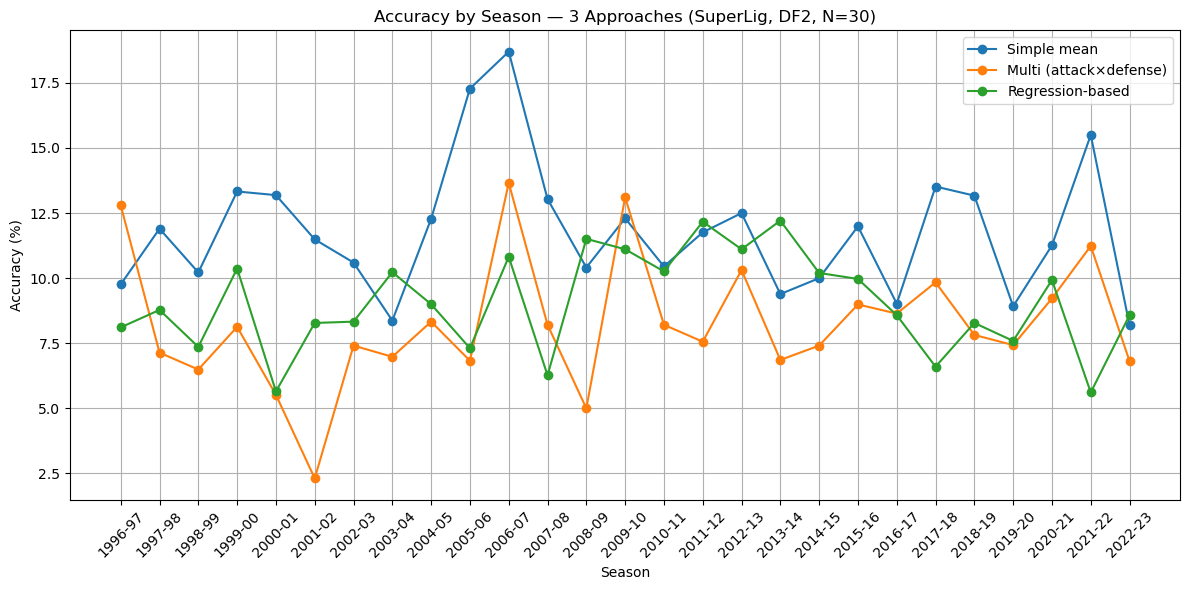

=== Average accuracy (%) across seasons ===
Simple mean             : 11.80
Multi (attack×defense)  : 8.23
Regression-based (roll) : 9.05

Best on average: Simple mean


In [83]:
# ========= 5) PLOT THE THREE DICTS AND PRINT THE BEST =========
import matplotlib.pyplot as plt

def plot_and_compare_three(acc_simple: dict, acc_multi: dict, acc_reg: dict, title_suffix=""):
    # Align seasons across all three dicts and keep chronological order
    seasons_all = sorted(set(acc_simple.keys()) & set(acc_multi.keys()) & set(acc_reg.keys()))
    y_simple = [acc_simple[s] for s in seasons_all]
    y_multi  = [acc_multi[s]  for s in seasons_all]
    y_reg    = [acc_reg[s]    for s in seasons_all]

    plt.figure(figsize=(12,6))
    plt.plot(seasons_all, y_simple, marker='o', label='Simple mean')
    plt.plot(seasons_all, y_multi,  marker='o', label='Multi (attack×defense)')
    plt.plot(seasons_all, y_reg,    marker='o', label='Regression-based')
    plt.xticks(rotation=45)
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Season')
    plt.title(f'Accuracy by Season — 3 Approaches {title_suffix}'.strip())
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    avg_simple = float(np.mean(y_simple)) if y_simple else 0.0
    avg_multi  = float(np.mean(y_multi))  if y_multi  else 0.0
    avg_reg    = float(np.mean(y_reg))    if y_reg    else 0.0

    print("=== Average accuracy (%) across seasons ===")
    print(f"Simple mean             : {avg_simple:.2f}")
    print(f"Multi (attack×defense)  : {avg_multi:.2f}")
    print(f"Regression-based (roll) : {avg_reg:.2f}")

    best_label = max(
        [('Simple mean', avg_simple), ('Multi (attack×defense)', avg_multi), ('Regression-based (roll)', avg_reg)],
        key=lambda x: x[1]
    )[0]
    print(f"\nBest on average: {best_label}")

# Use it:
plot_and_compare_three(acc_simple, acc_multi, acc_reg, title_suffix="(SuperLig, DF2, N=30)")


Use low score adjustment to improve the accuracy

In [84]:
import pandas as pd
import numpy as np
from scipy.stats import poisson
from scipy.optimize import minimize

# τ adjustment function for low scores
def tau(x, y, lambda_home, lambda_away, rho):
    if x == 0 and y == 0:
        return 1 - lambda_home * lambda_away * rho
    elif x == 0 and y == 1:
        return 1 + lambda_home * rho
    elif x == 1 and y == 0:
        return 1 + lambda_away * rho
    elif x == 1 and y == 1:
        return 1 - rho
    else:
        return 1.0

# Log-likelihood function
def dc_log_likelihood(rho, matches, past_n=50):
    log_like = 0
    for i, row in matches.iterrows():
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        match_date = row['Date']

        # Past matches for mean λ
        past_home = matches[(matches['HomeTeam'] == home_team) & (matches['Date'] < match_date)].tail(past_n)
        past_away = matches[(matches['AwayTeam'] == away_team) & (matches['Date'] < match_date)].tail(past_n)

        if len(past_home) < past_n or len(past_away) < past_n:
            continue

        lambda_home = past_home['HomeGoals'].mean()
        lambda_away = past_away['AwayGoals'].mean()

        # Poisson probability
        prob = poisson.pmf(row['HomeGoals'], lambda_home) * poisson.pmf(row['AwayGoals'], lambda_away)

        # Apply Dixon–Coles adjustment
        prob *= tau(row['HomeGoals'], row['AwayGoals'], lambda_home, lambda_away, rho)

        # Avoid log(0) errors
        if prob > 0:
            log_like += np.log(prob)

    return -log_like  # We minimize the negative log-likelihood

# === Example usage ===
df4['Date'] = pd.to_datetime(df4['Date'], dayfirst=True)
rho_result = minimize(dc_log_likelihood, x0=[0.0], args=(df4, 50), bounds=[(-1, 1)])
best_rho = rho_result.x[0]

print(f"Best rho from MLE: {best_rho:.4f}")


Best rho from MLE: -1.0000


In [85]:
# simple mean approach + Dixon–Coles low-score adjustment

import pandas as pd
import numpy as np
from scipy.stats import poisson
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

def run_poisson_prediction(df_input, past_n=50, rho=-0.1):
    """
    past_n : number of past matches for each team
    rho    : Dixon–Coles low-score correlation parameter (e.g., -0.1). Use 0.0 to disable.
    """
    df_copy = df_input.copy()
    df_copy['Date'] = pd.to_datetime(df_copy['Date'], dayfirst=True, errors='coerce')
    df_copy = df_copy.dropna(subset=['Date']).sort_values('Date').reset_index(drop=True)
    df_copy['PredictionMatch'] = '0'

    # Dixon–Coles tau adjustment for low scores
    def tau_dc(x, y, lam_h, lam_a, rho):
        if rho == 0.0:
            return 1.0
        if x == 0 and y == 0:
            return 1.0 - lam_h * lam_a * rho
        if x == 0 and y == 1:
            return 1.0 + lam_h * rho
        if x == 1 and y == 0:
            return 1.0 + lam_a * rho
        if x == 1 and y == 1:
            return 1.0 - rho
        return 1.0

    def predict_match(row, df_data):
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        match_date = row['Date']

        # Past matches
        past_home = df_data[(df_data['HomeTeam'] == home_team) & (df_data['Date'] < match_date)] \
                        .sort_values('Date', ascending=False).head(past_n)
        past_away = df_data[(df_data['AwayTeam'] == away_team) & (df_data['Date'] < match_date)] \
                        .sort_values('Date', ascending=False).head(past_n)

        if len(past_home) < past_n or len(past_away) < past_n:
            return '0'

        # Simple mean λ's
        lambda_home = past_home['HomeGoals'].mean()
        lambda_away = past_away['AwayGoals'].mean()

        # Score prediction matrix with DC adjustment
        max_goals = 10
        score_matrix = np.zeros((max_goals + 1, max_goals + 1))
        for i in range(max_goals + 1):
            for j in range(max_goals + 1):
                p = poisson.pmf(i, lambda_home) * poisson.pmf(j, lambda_away)
                p *= tau_dc(i, j, lambda_home, lambda_away, rho)
                if p < 0:  # safety guard if rho is extreme
                    p = 0.0
                score_matrix[i, j] = p

        pred_home, pred_away = np.unravel_index(np.argmax(score_matrix), score_matrix.shape)
        return 'Yes' if (pred_home == row['HomeGoals']) and (pred_away == row['AwayGoals']) else 'No'

    # Seasons to check
    seasons_to_check = [f"{y}-{str(y+1)[-2:]}" for y in range(1996, 2023)]
    season_accuracies = []

    # Calculate season-wise accuracy
    for season in seasons_to_check:
        mask = df_copy['Season'] == season
        df_copy.loc[mask, 'PredictionMatch'] = df_copy[mask].apply(lambda row: predict_match(row, df_copy), axis=1)
        pred_df = df_copy[(df_copy['Season'] == season) & (df_copy['PredictionMatch'].isin(['Yes', 'No']))]
        correct = (pred_df['PredictionMatch'] == 'Yes').sum()
        total = len(pred_df)
        accuracy = correct / total if total > 0 else 0
        season_accuracies.append((season, round(accuracy * 100, 2)))

    # Create final table
    results_df = pd.DataFrame(season_accuracies, columns=['Season', 'Accuracy (%)'])
    avg_accuracy = round(results_df['Accuracy (%)'].mean(), 2)
    results_df = pd.concat([results_df, pd.DataFrame([{'Season': 'Average', 'Accuracy (%)': avg_accuracy}])], ignore_index=True)

    return results_df

# === Run only for df4 ===
# tweak rho here; try -0.05 to -0.2 range
results_df4 = run_poisson_prediction(df2, past_n=30, rho=best_rho)

print("\n=== Season-wise Accuracy for DF2 (Simple mean + Dixon–Coles, 30 matches) ===")
print(results_df4.to_string(index=False))



=== Season-wise Accuracy for DF2 (Simple mean + Dixon–Coles, 30 matches) ===
 Season  Accuracy (%)
1996-97          7.93
1997-98         13.33
1998-99         10.75
1999-00         12.86
2000-01         11.54
2001-02          9.20
2002-03         11.52
2003-04          5.58
2004-05         10.53
2005-06         13.58
2006-07         12.17
2007-08         10.63
2008-09          9.95
2009-10         15.16
2010-11         10.45
2011-12         10.08
2012-13         11.61
2013-14          9.39
2014-15         12.22
2015-16         10.11
2016-17          9.02
2017-18         10.66
2018-19         15.23
2019-20         10.41
2020-21         13.65
2021-22         12.18
2022-23          6.76
Average         10.98
